In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random

# 固定随机数种子
seed = 2410
np.random.seed(seed)
random.seed(seed)

In [3]:
# 定义混合高斯分布
def mixture_gaussian(x):
    """混合高斯分布：0.3N(4, 0.3) + 0.7N(7, 2)"""
    return 0.3 * np.exp(-0.5 * (x - 4)**2 / 0.3) / np.sqrt(2 * np.pi * 0.3) + \
           0.7 * np.exp(-0.5 * (x - 7)**2 / 2) / np.sqrt(2 * np.pi * 2)

# 目标分布的负对数（用于势能）
def potential_energy(q):
    """目标分布的势能，即负对数密度"""
    return -np.log(mixture_gaussian(q))

# 势能的梯度（即目标分布的对数梯度）
def gradient_potential_energy(q):
    """计算势能的梯度"""
    epsilon = 1e-5
    return (potential_energy(q + epsilon) - potential_energy(q - epsilon)) / (2 * epsilon)

# HMC采样器
def hmc_sampler(num_samples, step_size, num_steps):
    samples = []
    q = np.random.uniform(-10, 10)  # 初始化位置

    for _ in range(num_samples):
        # 初始化动量
        p = np.random.normal(0, 1)  # 生成一个标准正态分布的动量

        # 保存当前状态
        q_new = q
        p_new = p

        # 模拟哈密顿力学轨迹
        p_new -= 0.5 * step_size * gradient_potential_energy(q_new)
        q_new += step_size * p_new
        p_new -= 0.5 * step_size * gradient_potential_energy(q_new)

        # Metropolis接受拒绝步骤
        current_H = 0.5 * p**2 + potential_energy(q)  # 当前的哈密顿量
        new_H = 0.5 * p_new**2 + potential_energy(q_new)  # 新的哈密顿量
        accept_prob = np.exp(current_H - new_H)  # 计算接受概率

        if np.random.rand() < accept_prob:
            q = q_new  # 如果接受新状态，则更新位置

        samples.append(q)

    return np.array(samples)

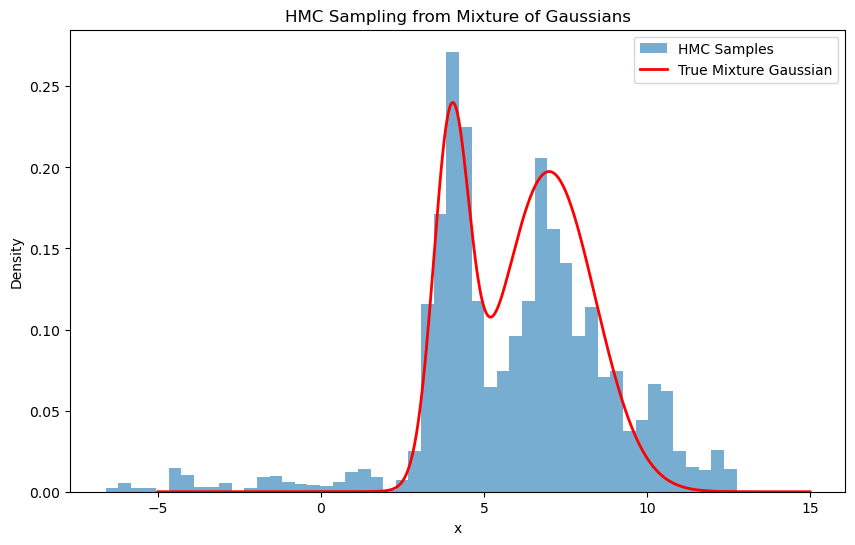

In [4]:
# 参数设置
num_samples = 10000
step_size = 0.1
L = 10

# 采样
samples = hmc_sampler(num_samples, step_size, L)

# 绘制采样结果的直方图
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, label='HMC Samples')

# 绘制目标分布
x_vals = np.linspace(-5, 15, 1000)
y_vals = mixture_gaussian(x_vals)
plt.plot(x_vals, y_vals, label="True Mixture Gaussian", color='r', lw=2)
plt.title('HMC Sampling from Mixture of Gaussians')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [7]:
mu_target = 0.3 * 4 + 0.7 * 7  # 理论均值
var_target = 0.3 * (0.3 + (4 - mu_target)**2) + 0.7 * (2 + (7 - mu_target)**2)  # 理论方差

# 计算样本的均值和方差
mu_sample = np.mean(samples)
var_sample = np.var(samples)

# 计算KL散度
# 通过数值积分计算KL散度
def kl_divergence(samples):
    dx = 0.1  # 设置积分步长
    x_vals = np.linspace(-5, 15, 1000)
    p_target = mixture_gaussian(x_vals)
    p_sample = np.histogram(samples, bins=100, density=True)[0]
    p_sample = p_sample / np.sum(p_sample)  # 归一化
    
    # 插值到相同的x_vals范围
    p_sample_interpolated = np.interp(x_vals, np.linspace(np.min(samples), np.max(samples), len(p_sample)), p_sample)
    
    # 计算KL散度
    kl = np.sum(p_target * np.log(p_target / p_sample_interpolated + 1e-10)) * dx  # 加上1e-10避免除零
    return kl

kl = kl_divergence(samples)

# 输出结果
print(f"理论均值: {mu_target:.4f}, 理论方差: {var_target:.4f}")
print(f"样本均值: {mu_sample:.4f}, 样本方差: {var_sample:.4f}")
print(f"KL散度: {kl:.4f}")

理论均值: 6.1000, 理论方差: 3.3800
样本均值: 5.9687, 样本方差: 8.5011
KL散度: 8.8939
